In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import pickle
import scipy

## Load and combine raw data from all three batches

In [2]:
batch1 = pickle.load(open(r'../Data/batch1.pkl', 'rb'))
#remove batteries that do not reach 80% capacity
del batch1['b1c8']
del batch1['b1c10']
del batch1['b1c12']
del batch1['b1c13']
del batch1['b1c22']

In [3]:
numBat1 = len(batch1.keys())
numBat1

41

In [4]:
batch2 = pickle.load(open(r'../Data/batch2.pkl','rb'))

In [5]:
# There are four cells from batch1 that carried into batch2, we'll remove the data from batch2
# and put it with the correct cell from batch1
batch2_keys = ['b2c7', 'b2c8', 'b2c9', 'b2c15', 'b2c16']
batch1_keys = ['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4']
add_len = [662, 981, 1060, 208, 482];

In [6]:
for i, bk in enumerate(batch1_keys):
    batch1[bk]['cycle_life'] = batch1[bk]['cycle_life'] + add_len[i]
    for j in batch1[bk]['summary'].keys():
        if j == 'cycle':
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j] + len(batch1[bk]['summary'][j])))
        else:
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j]))
    last_cycle = len(batch1[bk]['cycles'].keys())
    for j, jk in enumerate(batch2[batch2_keys[i]]['cycles'].keys()):
        batch1[bk]['cycles'][str(last_cycle + j)] = batch2[batch2_keys[i]]['cycles'][jk]

In [7]:
del batch2['b2c7']
del batch2['b2c8']
del batch2['b2c9']
del batch2['b2c15']
del batch2['b2c16']

In [8]:
numBat2 = len(batch2.keys())
numBat2

43

In [9]:
batch3 = pickle.load(open(r'../Data/batch3.pkl','rb'))
# remove noisy channels from batch3
del batch3['b3c37']
del batch3['b3c2']
del batch3['b3c23']
del batch3['b3c32']
del batch3['b3c42']
del batch3['b3c43']

In [10]:
numBat3 = len(batch3.keys())
numBat3

40

In [11]:
numBat = numBat1 + numBat2 + numBat3
numBat

124

In [12]:
bat_dict = {**batch1, **batch2, **batch3}

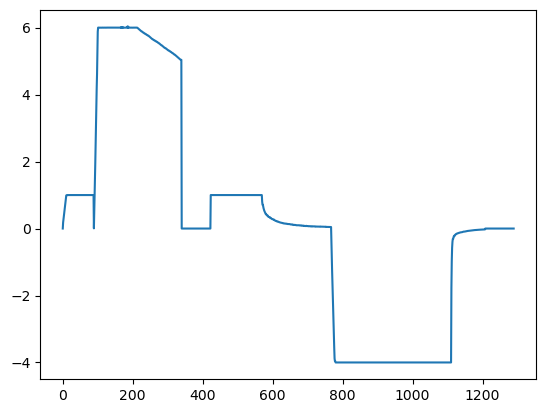

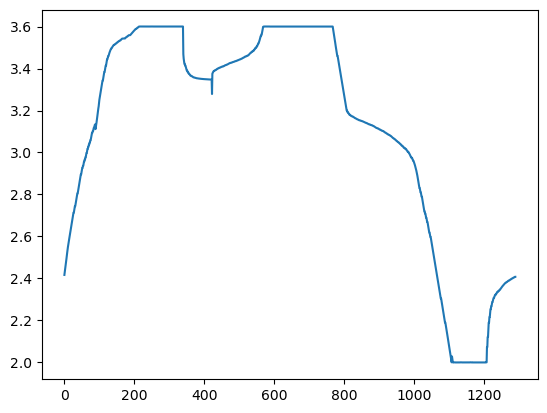

In [16]:
plt.plot(bat_dict["b2c0"]["cycles"]["10"]["I"])
plt.show()
plt.plot(bat_dict["b2c0"]["cycles"]["10"]["V"])

## Build dictionary

1364 1364
1000


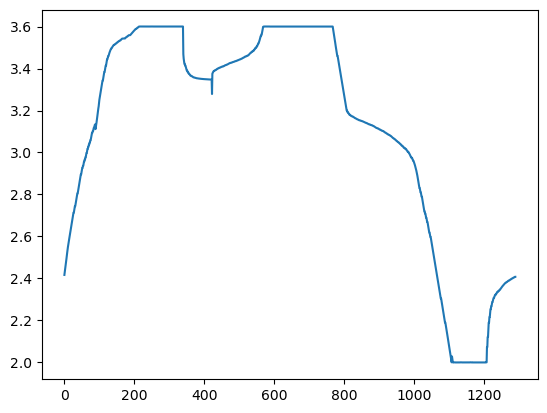

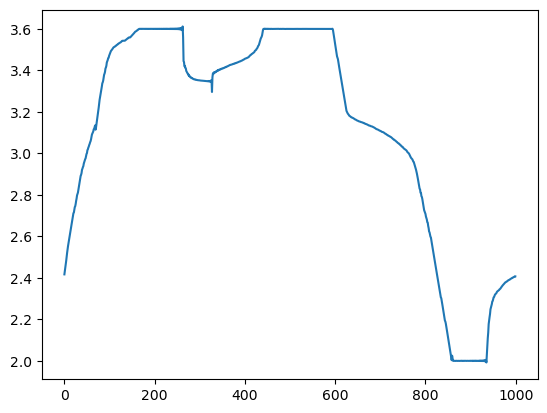

In [25]:
print(len(bat_dict["b2c0"]["cycles"]["100"]["Qd"]), len(bat_dict["b2c0"]["cycles"]["100"]["V"]))
print(len(bat_dict["b2c0"]["cycles"]["10"]["Qdlin"]))
plt.plot(bat_dict["b2c0"]["cycles"]["10"]["V"])
plt.show()
plt.plot(scipy.signal.resample(bat_dict["b2c0"]["cycles"]["10"]["V"], 1000))

## Calculate temperature features

#### Variance of temperature difference

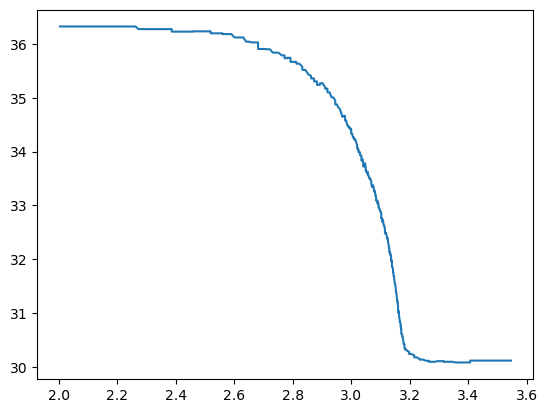

In [14]:
def crop_data_temp(id,cycle):
    # isolate discharging data
    cropped = np.array([[T, V] for T, Q, V in zip(bat_dict[id]["cycles"][cycle]["T"], bat_dict[id]["cycles"][cycle]["Qd"], bat_dict[id]["cycles"][cycle]["V"]) if Q > 1e-5])
    for i, datapoint in enumerate(cropped):
        if datapoint[1] < cropped[i+1, 1]:
            if datapoint[1] < 2.2: # identify where discharging ends
                end = i+1
                break
            else: # this is an anomalous increase in voltage; remove so voltage is decreasing
                cropped[i+1, 1] = cropped[i, 1]
    cropped = cropped[:end]    
    x = cropped[:, 1]
    y = cropped[:, 0]
    return x,y

x, y = crop_data_temp("b1c15", "10")
plt.plot(x, y)

In [54]:
def get_var_temp(id, cycle1, cycle2):
    x_100,y_100 = crop_data_temp(id, cycle1)
    x_10,y_10 = crop_data_temp(id,cycle2)
    q1 = scipy.signal.resample(np.convolve(y_100, np.array([1, 2, 1])/4, "same"), 200)
    q2 = scipy.signal.resample(np.convolve(y_10, np.array([1, 2, 1])/4, "same"), 200)
    return np.log10(np.var(q1-q2)+1e-8)

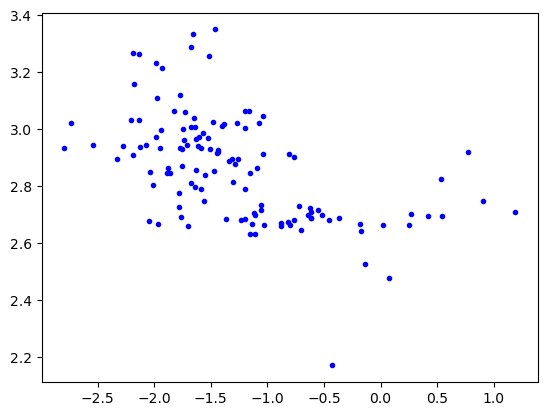

In [58]:
for id in bat_dict.keys():
    deltaT_var_list = []
    # plt.plot(np.log10(bat_dict[id]["cycle_life"]), bat_dict[id]["summary"]["Tmin"][100] - bat_dict[id]["summary"]["Tmin"][10], ".b")
    plt.plot(get_var_temp(id, "100", "10"),np.log10(bat_dict[id]["cycle_life"]),  ".b")
    for i in range(3, 100, 2):
        i = str(i)
        deltaT_var_list.append(get_var_temp(id, i, "3"))
    data_new[id]["DeltaT_var"] = np.array(deltaT_var_list)

#### Difference of temperature maxima

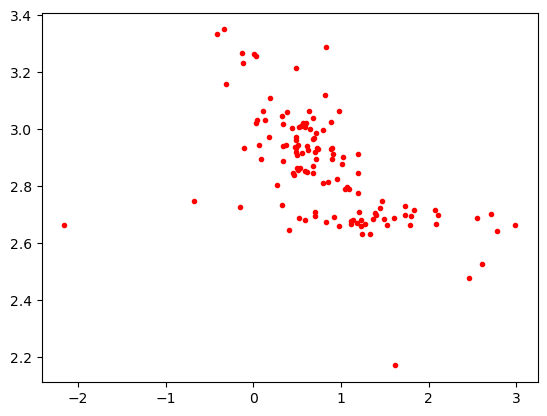

In [59]:
for id in bat_dict.keys():
    delta_T_list = []
    # plt.plot(np.log10(bat_dict[id]["cycle_life"]), bat_dict[id]["summary"]["Tmin"][100] - bat_dict[id]["summary"]["Tmin"][10], ".b")
    plt.plot(bat_dict[id]["summary"]["Tmax"][100] - bat_dict[id]["summary"]["Tmax"][10],np.log10(bat_dict[id]["cycle_life"]),  ".r")
    for i in range(4, 101, 2):
        delta_T_list.append(bat_dict[id]["summary"]["Tmax"][i] - bat_dict[id]["summary"]["Tmax"][4])
    data_new[id]["Delta_Tmax"] = np.array(delta_T_list)

In [63]:
with open('../Data/temp_features.pkl','wb') as fp:
        pickle.dump(data_new,fp)

#### Internal Resistance 
(not great)

## Calculate variance feature

In [50]:
def crop_data(id,cycle):
    # isolate discharging data
    cropped = np.array([[Q, V] for Q, V in zip(bat_dict[id]["cycles"][cycle]["Qd"], bat_dict[id]["cycles"][cycle]["V"]) if Q > 1e-5])
    for i, datapoint in enumerate(cropped):
        if datapoint[1] < cropped[i+1, 1]:
            if datapoint[1] < 2.2: # identify where discharging ends
                end = i+1
                break
            else: # this is an anomalous increase in voltage; remove so voltage is decreasing
                cropped[i+1, 1] = cropped[i, 1]
    cropped = cropped[:end]    
    x = np.flip(cropped[:, 1])
    y = np.flip(cropped[:, 0])
    return x,y

In [186]:
def get_discharge(id, cycle):
    # x = np.linspace(3.6, 2, 1000)
    x = bat_dict[id]["cycles"][cycle]["V"]
    y = bat_dict[id]["cycles"][cycle]["Qd"]
    return x, y

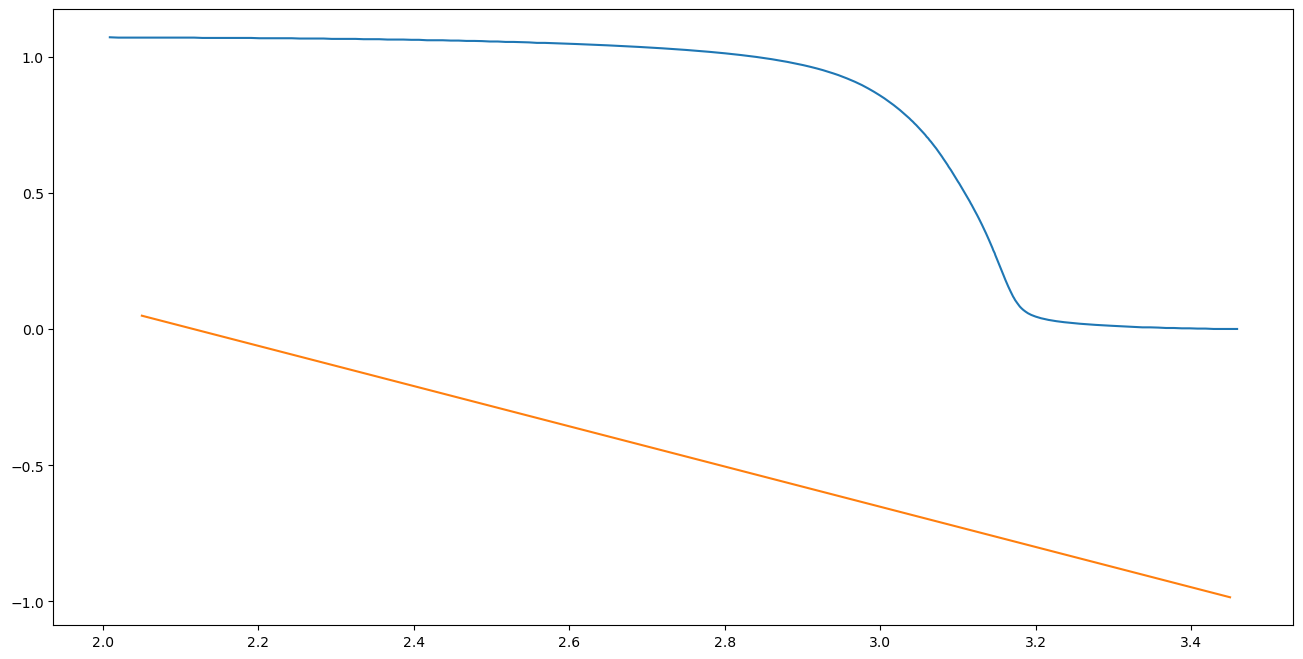

In [203]:
def RBF_thin_plate(x):
    return x**2*np.log(x)
def RBF_gaussian(x, a):
    return np.exp(-a*x**2)
def RBF_linear(x):
    return x
def RBF_multiquadratic(x, c):
    return np.sqrt(x**2 + c**2)

def interpolated(x, coeffs, x_list):
    y = 0
    for c, xi in zip(coeffs[:-2], x_list):
        y += c*RBF_linear(x-xi)
    y += coeffs[-2] + coeffs[-1]*x
    return y

x_list, y_list = crop_data("b2c20", "10")
stride = 3
N = len(x_list[::stride])
RBF_matrix = np.zeros((N, N))

for i, xi in enumerate(x_list[::stride]):
    for j, xj in enumerate(x_list[::stride]):
        RBF_matrix[i, j] = RBF_linear(np.abs(xi-xj))

RBF_matrix = np.vstack((RBF_matrix, np.ones(N), x_list[::stride])).T
RBF_matrix = np.vstack((RBF_matrix, np.concatenate((np.ones(N), np.zeros(2))), np.concatenate((x_list[::stride], np.zeros(2)))))
y_list2 = np.concatenate((y_list[::stride], np.zeros(2)))

coeffs = np.linalg.inv(RBF_matrix) @ y_list2

x_new = np.linspace(2.05, 3.45, 1000)
y_interpolated = interpolated(x_new, coeffs, x_list)
plt.plot(x_list, y_list)
plt.plot(x_new, y_interpolated)





337


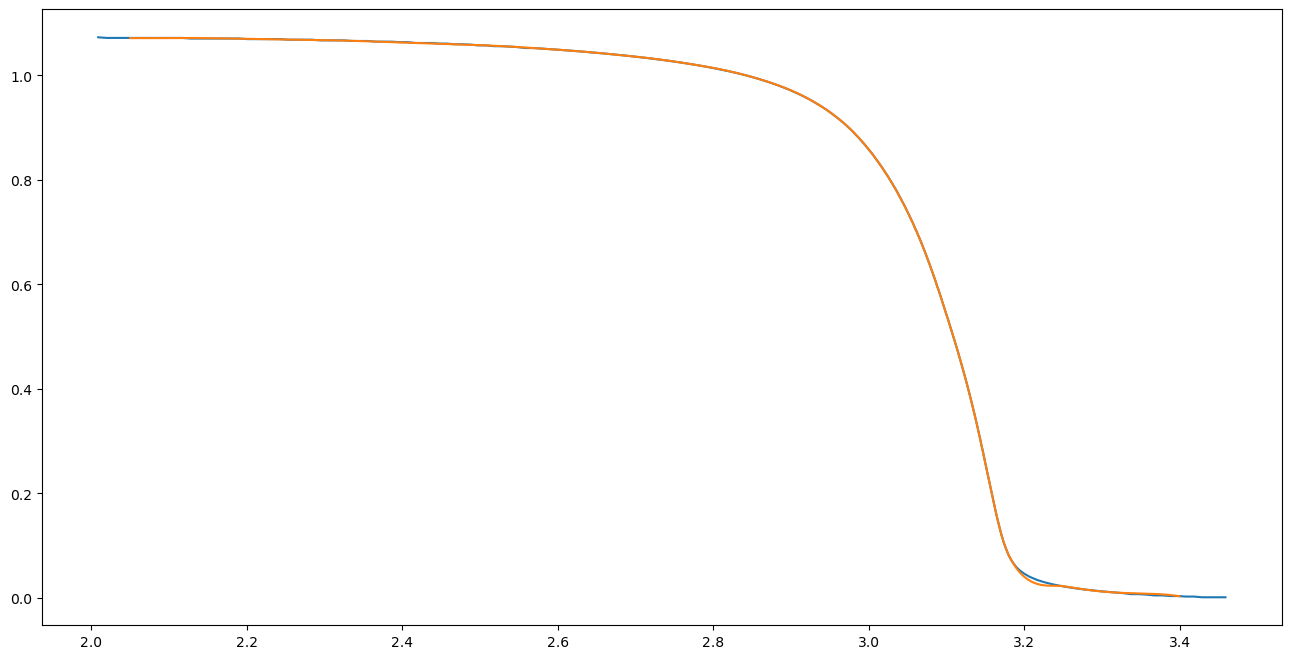

In [200]:
from scipy.interpolate import RBFInterpolator
# x_list = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
print(len(x_list))
y_interpolated = RBFInterpolator(x_list[::10, np.newaxis], y_list[::10])
x_new = np.linspace(2.05, 3.4, 1000)[:, np.newaxis]
plt.plot(x_list, y_list)
plt.plot(x_new, y_interpolated(x_new))

In [139]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RBFInterpolator
from scipy.stats.qmc import Halton

rng = np.random.default_rng()
xobs = 2*Halton(2, seed=rng).random(100) - 1

yobs = np.sum(xobs, axis=1)*np.exp(-6*np.sum(xobs**2, axis=1))
print(yobs.shape)
xgrid = np.mgrid[-1:1:50j, -1:1:50j]
xflat = xgrid.reshape(2, -1).T
yflat = RBFInterpolator(xobs, yobs)(xflat)
ygrid = yflat.reshape(50, 50)

(100,)


In [57]:
def get_var(id):
    x_100,y_100 = crop_data(id,"100")
    x_10,y_10 = crop_data(id,"10")
    print(len(y_100), len(y_10))
    y_100_resampled = scipy.signal.resample(y_100, 1000)
    y_10_resampled = scipy.signal.resample(y_10, 1000)
    return np.log10(np.var(y_100_resampled - y_10_resampled))

In [58]:
var_dict = []
for id in bat_dict.keys():
    if id[1] in ["2", "3"]: var_dict.append([get_var(id),np.log10(bat_dict[id]["cycle_life"])[0][0]])
    else: var_dict.append([get_var(id),np.log10(bat_dict[id]["cycle_life"])])
var_dict = np.array(var_dict)

340 335
339 338
341 335
339 342
323 332
320 330
332 344
342 345
343 329
339 338
331 348
330 347
334 333
322 331
327 339
336 338
334 339
331 340
325 332
337 338
348 344
346 337
350 358
331 358
340 341
344 354
338 361
345 340
330 342
322 353
328 335
350 343
337 334
343 338
325 345
366 344
348 336
350 343
346 335
331 334
334 336
325 332
296 331
334 322
319 335
338 349
335 349
331 333
341 342
332 350
324 333
338 351
328 348
337 343
334 325
330 326
346 337
338 342
336 326
313 345
327 318
343 328
337 336
330 326
332 320
333 345
325 342
339 337
343 347
328 343
318 330
323 339
339 352
332 336
329 335
337 336
315 318
332 335
322 335
321 341
323 338
339 341
339 343
333 319
269 260
259 268
260 269
266 268
263 257
254 266
269 259
260 263
261 262
259 261
260 265
259 261
259 263
267 269
262 262
259 266
272 267
260 262
267 264
263 262
259 262
258 267
265 258
265 271
265 273
259 270
254 269
267 265
265 270
264 263
268 268
259 263
260 267
263 262
265 263
256 259
268 259
256 258
264 270
267 271


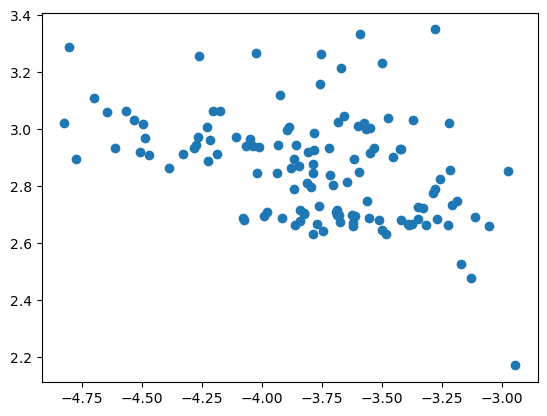

In [56]:
plt.scatter(var_dict[:,0],var_dict[:,1])
#plt.xlim(left=-6,right=-2)
#plt.ylim(top=3.5,bottom=2)

In [27]:
import scipy
scipy.stats.spearmanr(var_dict[:,0],var_dict[:,1])

SignificanceResult(statistic=-0.8764323593903243, pvalue=1.5617035163309112e-40)

In [29]:
with open('./Data/vardQ.pkl','wb') as fp:
        pickle.dump(var_dict,fp)

In [33]:
np.savetxt('./Data/vardQ.csv',var_dict,delimiter=',')

## To load data from csv

Each row takes form [log10(variance), log10(cycle lifetime)]

In [35]:
np.loadtxt('./Data/vardQ.csv',delimiter=',',skiprows=1) # skip row for column names

array([[-4.84,  3.27],
       [-4.99,  3.33],
       [-4.81,  3.35],
       [-4.37,  3.16],
       [-4.53,  3.23],
       [-4.14,  3.03],
       [-3.76,  2.8 ],
       [-3.81,  2.94],
       [-3.95,  3.02],
       [-4.09,  2.9 ],
       [-4.06,  2.94],
       [-3.95,  2.86],
       [-4.07,  2.94],
       [-3.97,  2.93],
       [-3.68,  2.84],
       [-3.62,  2.9 ],
       [-3.36,  2.73],
       [-3.34,  2.75],
       [-4.02,  3.01],
       [-3.92,  3.01],
       [-3.99,  2.93],
       [-3.78,  2.94],
       [-3.82,  2.93],
       [-3.83,  2.93],
       [-3.83,  2.96],
       [-3.75,  2.85],
       [-3.77,  2.94],
       [-3.65,  2.86],
       [-3.65,  2.88],
       [-3.82,  2.87],
       [-3.75,  2.85],
       [-3.65,  2.85],
       [-3.65,  2.81],
       [-3.45,  2.79],
       [-3.5 ,  2.8 ],
       [-4.07,  2.98],
       [-4.1 ,  3.02],
       [-3.65,  2.85],
       [-3.67,  2.81],
       [-3.43,  2.79],
       [-3.42,  2.78],
       [-2.78,  2.48],
       [-2.74,  2.17],
       [-3.

## Train and Test Split
If you are interested in using the same train/test split as the paper, use the indices specified below

In [34]:
test_ind = np.hstack((np.arange(0,(numBat1+numBat2),2),83))
train_ind = np.arange(1,(numBat1+numBat2-1),2)
secondary_test_ind = np.arange(numBat-numBat3,numBat);

In [35]:
test_ind

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
       34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
       68, 70, 72, 74, 76, 78, 80, 82, 83])

In [36]:
train_ind

array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
       69, 71, 73, 75, 77, 79, 81])

In [37]:
secondary_test_ind

array([ 84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
       123])